In [63]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pickle
import scipy.linalg
import torch
import time
from tqdm import trange
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

# PATH
import sys
sys.path.append('../../')
from sci.lib.loader import *
from sci.lib.recorder import * 
from sci.lib.utils import *

from sci.lib.seq.helper import *
from sci.lib.seq.models import *
from sci.lib.seq.parser import *

from sci.lib.vis.modes import *
from sci.lib.vis.post import *
from sci.lib.vis.reconstruct import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':20})
DPI = 60

#GLOBALS
KPP_DIR = '../data/KPP.npz'

# Data
## Data Loading

In [64]:
npdata = np.load(KPP_DIR)
xv, yv, kpp = npdata['arr_0'], npdata['arr_1'], npdata['arr_2']
shape = kpp.shape
print('Data Shape: {}'.format(kpp.shape))

Data Shape: (20, 20, 501)


## Data Visualization

In [65]:
def kpp_plot(kpp_t):
    plt.figure(figsize=(16, 6), dpi=80)
    ax = plt.axes(projection='3d')
    ax.plot_surface(xv, yv, kpp[:,:,kpp_t], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.legend()
    plt.title('Density $\\rho$')
    
interact_manual(kpp_plot, kpp_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='kpp_t', max=500), Button(description='Run Interact', sty…

<function __main__.kpp_plot(kpp_t)>

# Proper Orthogonal Decomposition

## Method

In [66]:
def PODKPP(data, s_ind, e_ind, modes):
    """ Computes the spatial modes and temporal coefficients using the POD """
    # velocity in x
    var1 = data[:, :, s_ind:e_ind]
    var1 = np.moveaxis(var1, [0, 1, 2], [1, 2, 0])

    # taking the temporal mean of snapshots
    var1_mean = np.mean(var1, axis=0)[np.newaxis, ...]

    # fluctuating components: taking U-Um
    var1 = var1 - var1_mean
    
    # return copies
    var1_copy = np.copy(var1)

    # Reshaping to create snapshot matrix Y with dimension [time, NxM]
    shape = var1.shape
    var1 = var1.reshape(shape[0], shape[1] * shape[2])
    Y = var1

    # Snapshot Method:
    Cs = np.matmul(Y, Y.T)

    # L:eigvals, As:eigvecs
    Lv, As = scipy.linalg.eigh(Cs)

    # descending order
    Lv = Lv[Lv.shape[0]::-1]
    As = As[:, Lv.shape[0]::-1]

    perc = sum(Lv[:modes])/sum(Lv)

    spatial_modes = np.matmul(Y.T, As[:, :modes]) / np.sqrt(Lv[:modes])
    temporal_coefficients = np.matmul(Y, spatial_modes)  #"throw sqrt of Lv onto temp_coef"

    return spatial_modes, temporal_coefficients, Lv, var1_copy, perc


## Reduced KPP Data
From $t=0$ to $t=500$

In [67]:
s_ind = 0
Nxy = shape[0]*shape[1]
e_ind = shape[2]
pod_modes = 12
spatial_modes, data, eigenvalues, kpp_mean, perc = PODKPP(kpp, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data.shape))
print("ACCOUNTED RECOVER: {}".format(perc))

REDUCED MODEL SHAPE: (501, 12)
ACCOUNTED RECOVER: 0.9992292725405285


## Visualzation of Reduced Data

In [68]:
pod_true = np.matmul(data, spatial_modes.T)
pod_h = pod_true.reshape(shape[2],shape[0],shape[1])

### Mean Subtracted Difference

In [69]:
def kpp_Reconstructed(rec_kpp_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    ax = plt.subplot(121, projection='3d')
    ax.plot_surface(xv, yv, kpp[:,:,rec_kpp_t], cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax = plt.subplot(122, projection='3d')
    ax.plot_surface(xv, yv, kpp_mean[rec_kpp_t,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)

interact_manual(kpp_Reconstructed, rec_kpp_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='rec_kpp_t', max=500), Button(description='Run Interact',…

<function __main__.kpp_Reconstructed(rec_kpp_t)>

### Mean Subtracted FOM vs ROM

In [70]:
def kpp_fullReduced(kpp_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    ax = plt.subplot(121, projection='3d')
    ax.plot_surface(xv, yv, kpp_mean[kpp_t,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax = plt.subplot(122, projection='3d')
    ax.plot_surface(xv, yv, pod_h[kpp_t,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)

interact_manual(kpp_fullReduced, kpp_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='kpp_t', max=500), Button(description='Run Interact', sty…

<function __main__.kpp_fullReduced(kpp_t)>

### Animation FOM vs ROM

MovieWriter PillowWriter unavailable; using Pillow instead.


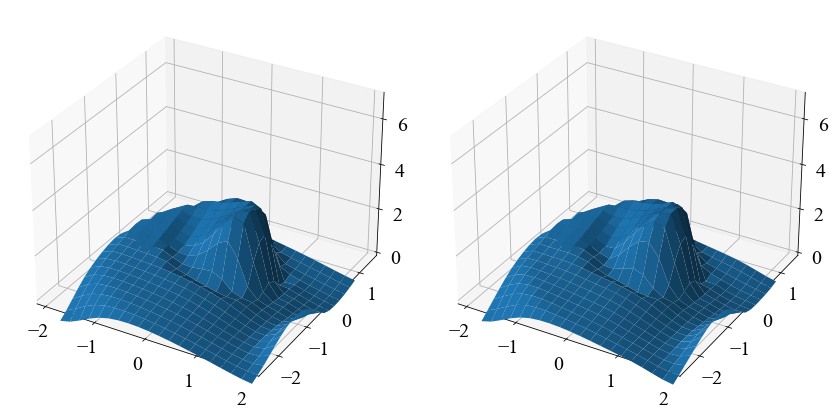

In [71]:
fig = plt.figure(figsize=(12,12), tight_layout=True)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_zlim(0, 7)
ax2.set_zlim(0, 7)
axes = [ax1, ax2]
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
titles = ['FOM $U_x$', 'ROM $\\tilde{U}_x$']
lines = []
for i,ax in enumerate(axes):
    ax.set_title(titles[i])
    lines = lines + [ax.plot_surface(xv, yv, np.ones((20,20)))]
    

def run(kpp_t, ax1, ax2):

    data = [kpp_mean, pod_h]
    lines=[]
    axes = [ax1, ax2]
    for i,ax in enumerate(axes):
        ax.clear()
        ax.set_zlim(0, 7)
        lines = lines + [ax.plot_surface(xv, yv, data[i][kpp_t, :,:])]

    return lines


ani = animation.FuncAnimation(fig, run, fargs=(axes), blit=True, repeat=False)
ani.save('../out/KPP/anim_rom.gif', "PillowWriter", fps=5)

### Plot of POD Modes

No handles with labels found to put in legend.


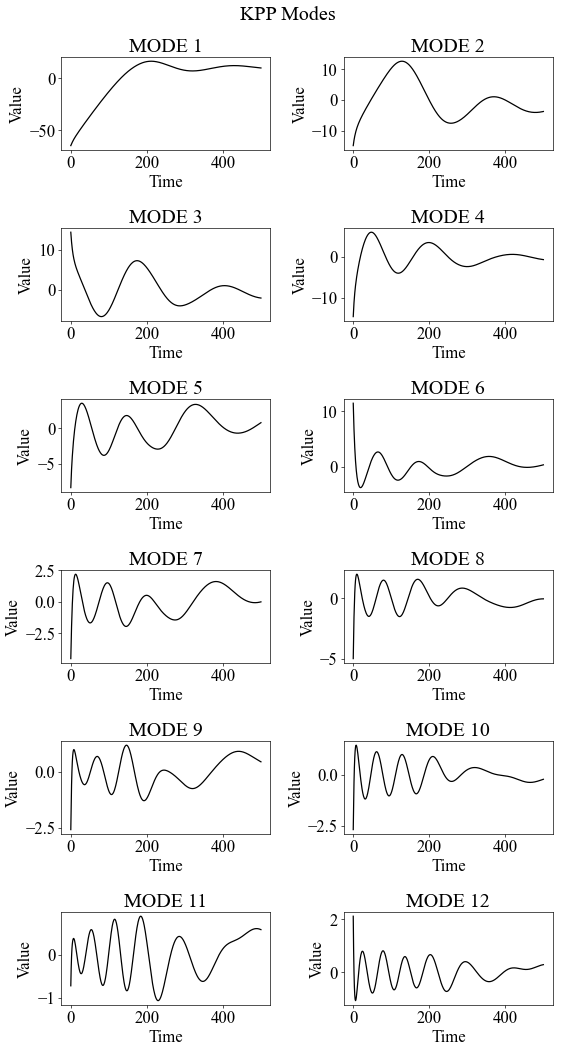

In [72]:
plt.figure(figsize=(10, 3*pod_modes//2), tight_layout=True, dpi=DPI)
plt.suptitle("KPP Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data[:,i], 'k')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/KPP/podModes.pdf', format="pdf", bbox_inches="tight")

## Plot of POD Mode Loss

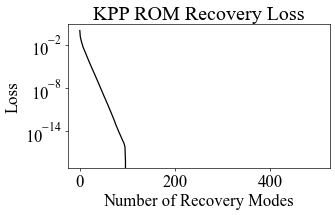

In [73]:
total = sum(eigenvalues)
data = []
cumulative=[1]

for eig in eigenvalues:
    val = eig/total
    data = data + [val]
    cumulative = cumulative + [cumulative[-1]-val]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("KPP ROM Recovery Loss")
plt.yscale('log')
plt.plot(x2,cumulative, 'k')
plt.xlabel('Number of Recovery Modes')
plt.ylabel('Loss')
plt.savefig('../out/KPP/pod_loss.pdf', format="pdf", bbox_inches="tight")

# Model

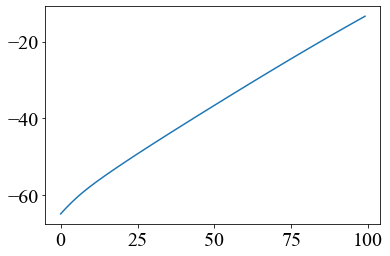

In [ ]:
seq_win = 25
tr_win = 100
val_win = 150
device = 'cpu'
plt.plot(data[:100,0])

In [ ]:
total_size = data.shape[0] - seq_win
#SEQUENCE DATA
seq_data = np.vstack([[data[t:t + seq_win, :] for t in range(total_size-1)]]).swapaxes(0,1)
seq_label = np.vstack([[data[t+1:t+seq_win+1, :] for t in range(total_size-1)]]).swapaxes(0,1)
print(seq_label.shape)

(25, 475, 4)


(25, 475, 4) (25, 475, 4)


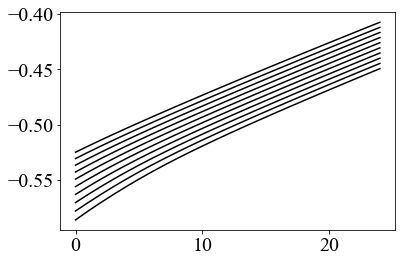

In [ ]:
print(seq_data.shape, seq_label.shape)
plt.plot(seq_data[:,:10,0],'k')
plt.show()

In [ ]:
# training data
train_data = seq_data[:, :tr_win-seq_win, :]
train_label = seq_label[:, :tr_win-seq_win, :]
train_data =  torch.FloatTensor(train_data).to(device)
train_label = torch.FloatTensor(train_label).to(device)
train_times = (torch.ones(train_data.shape[:-1])/train_data.shape[1]).to(device)

torch.Size([25, 75, 4])


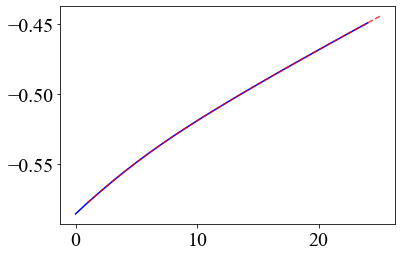

In [ ]:
print(train_label.shape)
plt.plot(train_data[:,0,0], color='b')
plt.plot(np.arange(seq_win+1)[1:],train_label[:,0,0], 'r--', alpha=.75)

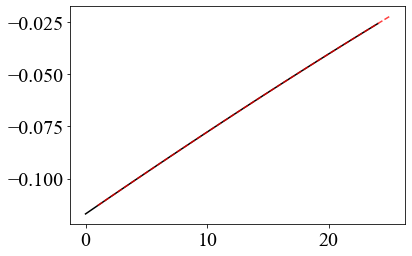

In [ ]:
# validation data
val_data = seq_data[:, tr_win:val_win-seq_win, :]
val_label = seq_label[:, tr_win:val_win-seq_win, :]
val_data =  torch.FloatTensor(val_data).to(device)
val_label = torch.FloatTensor(val_label).to(device)
val_times = (torch.ones(val_data.shape[:-1])/val_data.shape[1]).to(device)
plt.plot(val_data[:,0,0], color='k')
plt.plot(np.arange(seq_win+1)[1:],val_label[:,0,0], 'r--', alpha=.75)

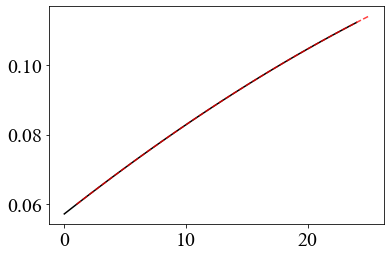

In [ ]:
# validation data
eval_data = seq_data[:, val_win:, :]
eval_label = seq_label[:, val_win:, :]
eval_data =  torch.FloatTensor(eval_data).to(device)
eval_label = torch.FloatTensor(eval_label).to(device)
eval_times = (torch.ones(eval_data.shape[:-1])/eval_data.shape[1]).to(device)
plt.plot(eval_data[:,0,0], color='k')
plt.plot(np.arange(seq_win+1)[1:],eval_label[:,0,0], 'r--', alpha=.75)

In [ ]:
print(train_data.shape, train_times.shape, train_label.shape)
print(val_data.shape, val_label.shape)
print(eval_data.shape, eval_label.shape)

torch.Size([25, 75, 4]) torch.Size([25, 75]) torch.Size([25, 75, 4])
torch.Size([25, 25, 4]) torch.Size([25, 25, 4])
torch.Size([25, 325, 4]) torch.Size([25, 325, 4])


In [ ]:
args = parse_args([])
args.data_dir = '../data/KPP.npz'
args.dataset = 'KPP'
args.out_dir = '../out/IPYNB/'
args.batch_size = 10
args.epochs = 20
args.modes = 4
args.tstart = 100
args.tr_win = 200
args.val_win = 250
args.seq_win = 30


In [ ]:
set_outdir(args.out_dir, args)
model = HBMODEL(args, res=True, cont=True)
DL = SEQ_LOADER(args)
print(DL.train_data.shape, DL.train_times.shape, DL.train_label.shape)
print(DL.valid_data.shape, DL.valid_label.shape)
print(DL.eval_data.shape, DL.eval_label.shape)

Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 4
torch.Size([30, 170, 4]) torch.Size([30, 170]) torch.Size([30, 170, 4])
torch.Size([30, 20, 4]) torch.Size([30, 20, 4])
torch.Size([30, 119, 4]) torch.Size([30, 119, 4])


In [ ]:
#LEARNING UTILITIES
gradrec = True
torch.manual_seed(0)
rec = Recorder()
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
loss_meter_t = RunningAverageMeter()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                factor=args.factor, patience=args.patience, verbose=args.verbose, threshold=1e-5,
                threshold_mode='rel', cooldown=args.cooldown, min_lr=1e-7, eps=1e-08)

Training ...
torch.Size([30, 10, 4])


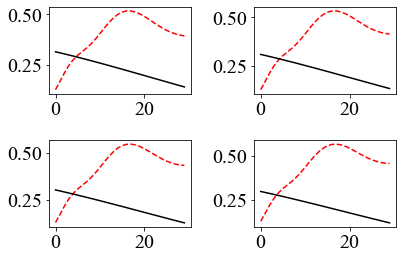

torch.Size([30, 10, 4])


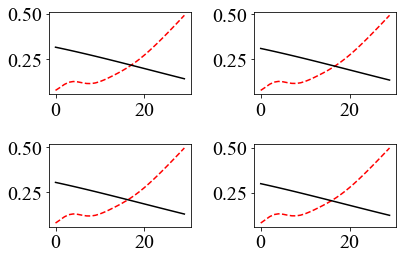

torch.Size([30, 10, 4])


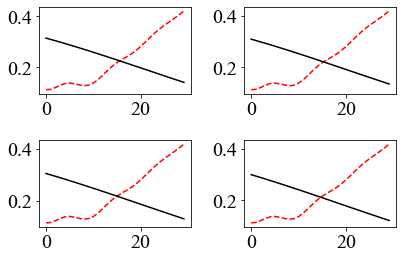

torch.Size([30, 10, 4])


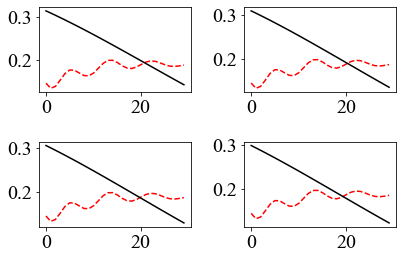

torch.Size([30, 10, 4])


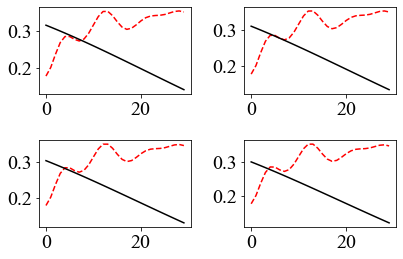

torch.Size([30, 10, 4])


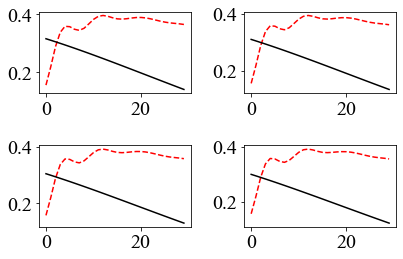

torch.Size([30, 10, 4])


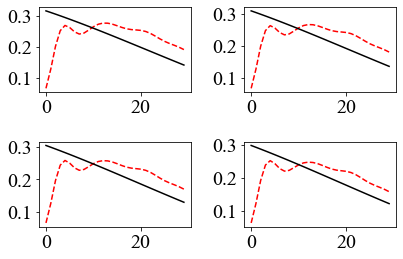

torch.Size([30, 10, 4])


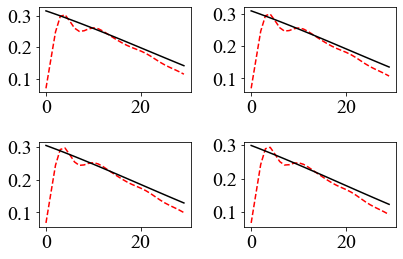

torch.Size([30, 10, 4])


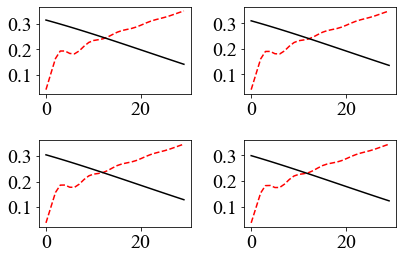

torch.Size([30, 10, 4])


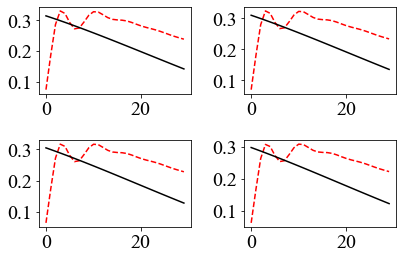

torch.Size([30, 10, 4])


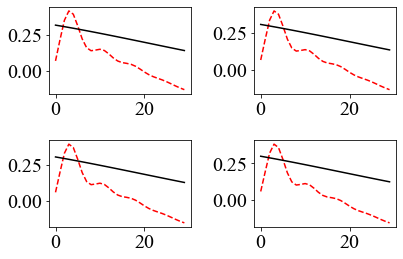

torch.Size([30, 10, 4])


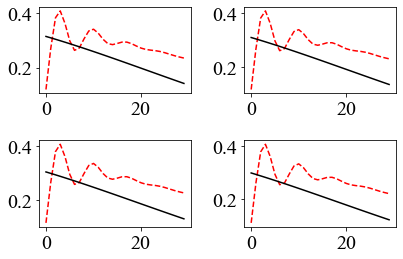

torch.Size([30, 10, 4])


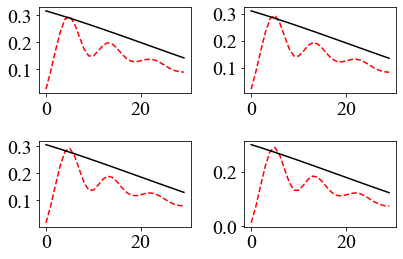

torch.Size([30, 10, 4])


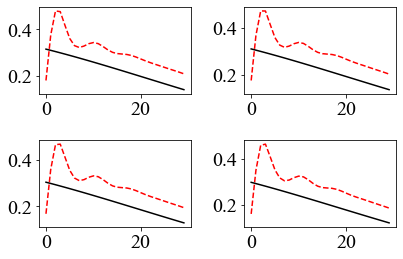

torch.Size([30, 10, 4])


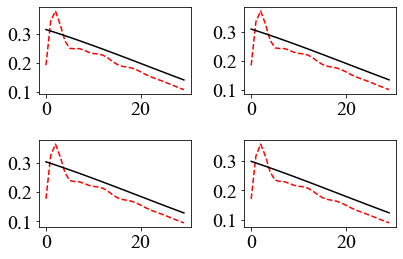

torch.Size([30, 10, 4])


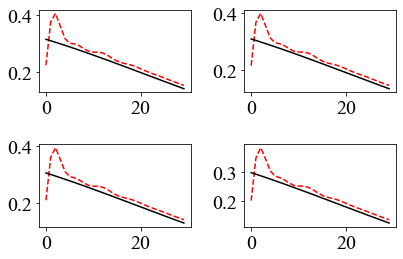

torch.Size([30, 10, 4])


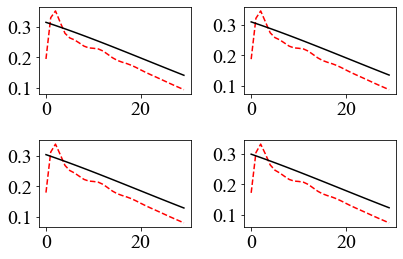

torch.Size([30, 10, 4])


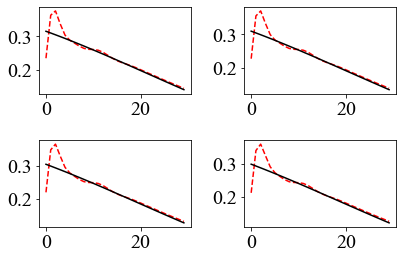

torch.Size([30, 10, 4])


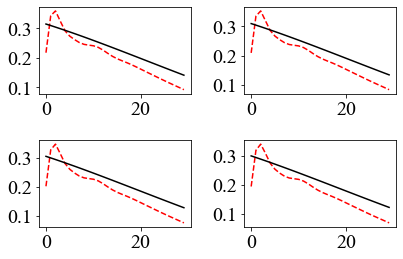

torch.Size([30, 10, 4])


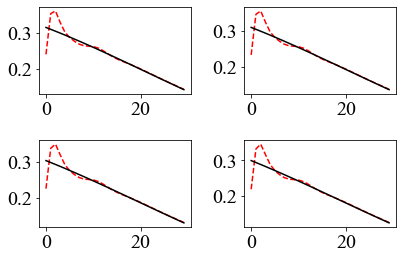

In [ ]:
print("Training ...")
# TRAINING
for epoch in range(args.epochs):

    rec['epoch'] = epoch
    batchsize = args.batch_size
    train_start_time = time.time()

    #SCHEDULER
    for param_group in optimizer.param_groups:
        rec['lr'] = param_group['lr']
    scheduler.step(metrics=loss_meter_t.avg)

    #BATCHING
    for b_n in range(0, DL.train_data.shape[1], batchsize):
        model.cell.nfe = 0
        predict = model(DL.train_times[:, b_n:b_n + batchsize], DL.train_data[:, b_n:b_n + batchsize])
        loss = criteria(predict, DL.train_label[:, b_n:b_n + batchsize])
        loss_meter_t.update(loss.item())
        rec['loss'] = loss

        #BACKPROP
        if gradrec is not None:
            lossf = criteria(predict[-1], DL.train_label[-1, b_n:b_n + batchsize])
            lossf.backward(retain_graph=True)
            vals = model.ode_rnn.h_rnn
            for i in range(len(vals)):
                grad = vals[i].grad
                rec['grad_{}'.format(i)] = 0 if grad is None else torch.norm(grad)
            model.zero_grad()
        model.cell.nfe = 0
        loss.backward()
        rec['backward_nfe'] = model.cell.nfe
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    plt.figure(tight_layout=True)
    print(predict.shape)
    plt.subplot(221)
    plt.plot(predict[:,0,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,0,0].detach().numpy(), 'k', label='True')
    plt.subplot(222)
    plt.plot(predict[:,1,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,1,0].detach().numpy(), 'k', label='True')
    plt.subplot(223)
    plt.plot(predict[:,2,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,2,0].detach().numpy(), 'k', label='True')
    plt.subplot(224)
    plt.plot(predict[:,3,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,3,0].detach().numpy(), 'k', label='True')

    # plt.legend()
    # plt.title("Epoch {}".format(epoch))
    plt.show()

    rec['train_time'] = time.time() - train_start_time

    #VALIDATION
    if epoch == 0 or (epoch + 1) % 1 == 0:
        model.cell.nfe = 0
        predict = model(DL.valid_times, DL.valid_data)
        vloss = criteria(predict, DL.valid_label)
        rec['va_nfe'] = model.cell.nfe
        rec['va_loss'] = vloss

    #TEST
    if epoch == 0 or (epoch + 1) % 5 == 0:
        model.cell.nfe = 0
        predict = model(DL.eval_times, DL.eval_data)
        sloss = criteria(predict, DL.eval_label)
        sloss = sloss.detach().cpu().numpy()
        rec['ts_nfe'] = model.cell.nfe
        rec['ts_loss'] = sloss

    #OUTPUT
    rec.capture(verbose=False)
    if (epoch + 1) % 5 == 0:
        torch.save(model, args.out_dir+'/pth/{}.mdl'.format(args.model))
        rec.writecsv(args.out_dir+'/pth/{}.csv'.format(args.model))


In [ ]:
args.verbose = True

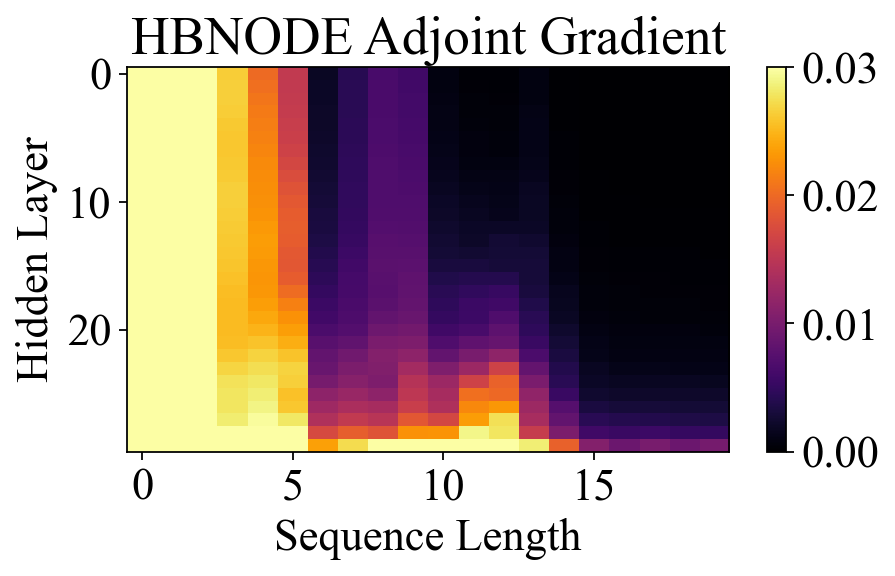

1

In [ ]:
plot_AdjGrad(args.out_dir+'/pth/{}.csv'.format(args.model),args)

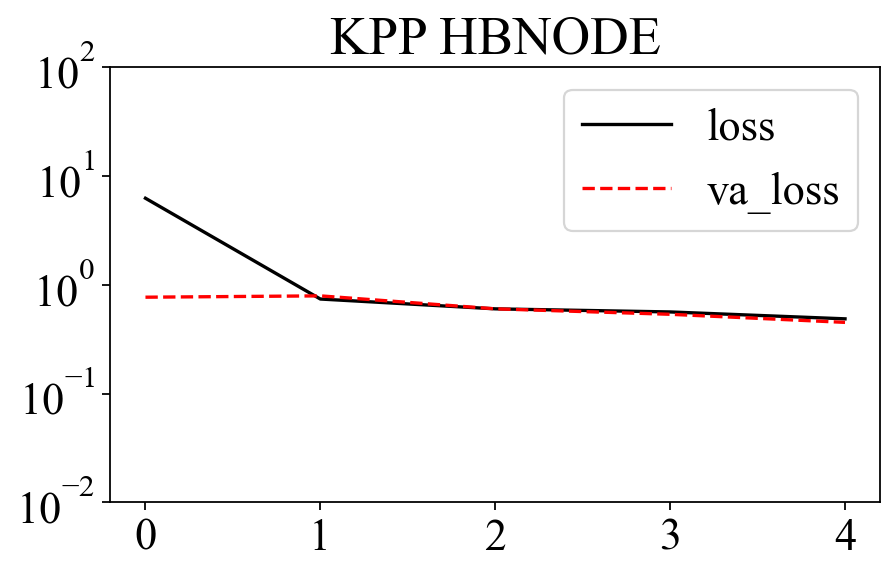

1

In [ ]:
plot_Loss(args.out_dir+'/pth/{}.csv'.format(args.model),args)

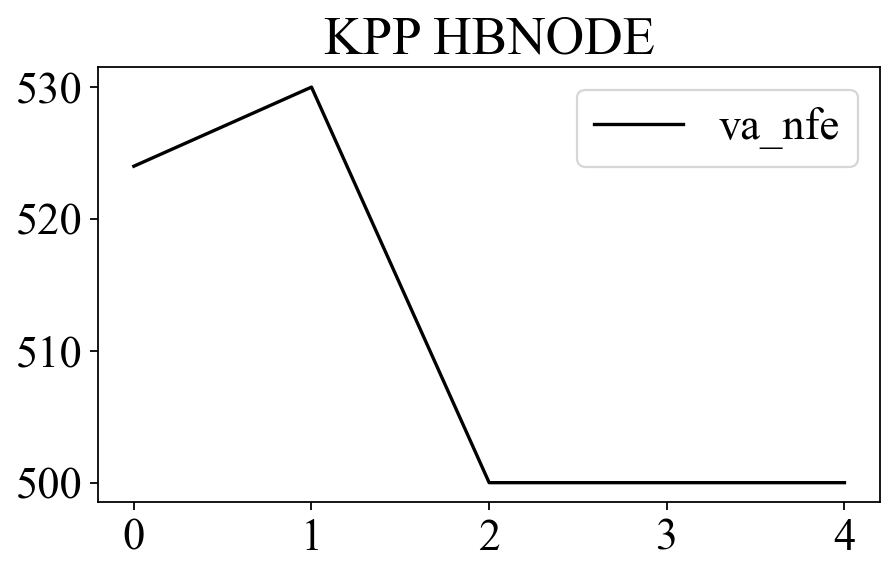

1

In [ ]:
plot_NFE(args.out_dir+'/pth/{}.csv'.format(args.model),args)


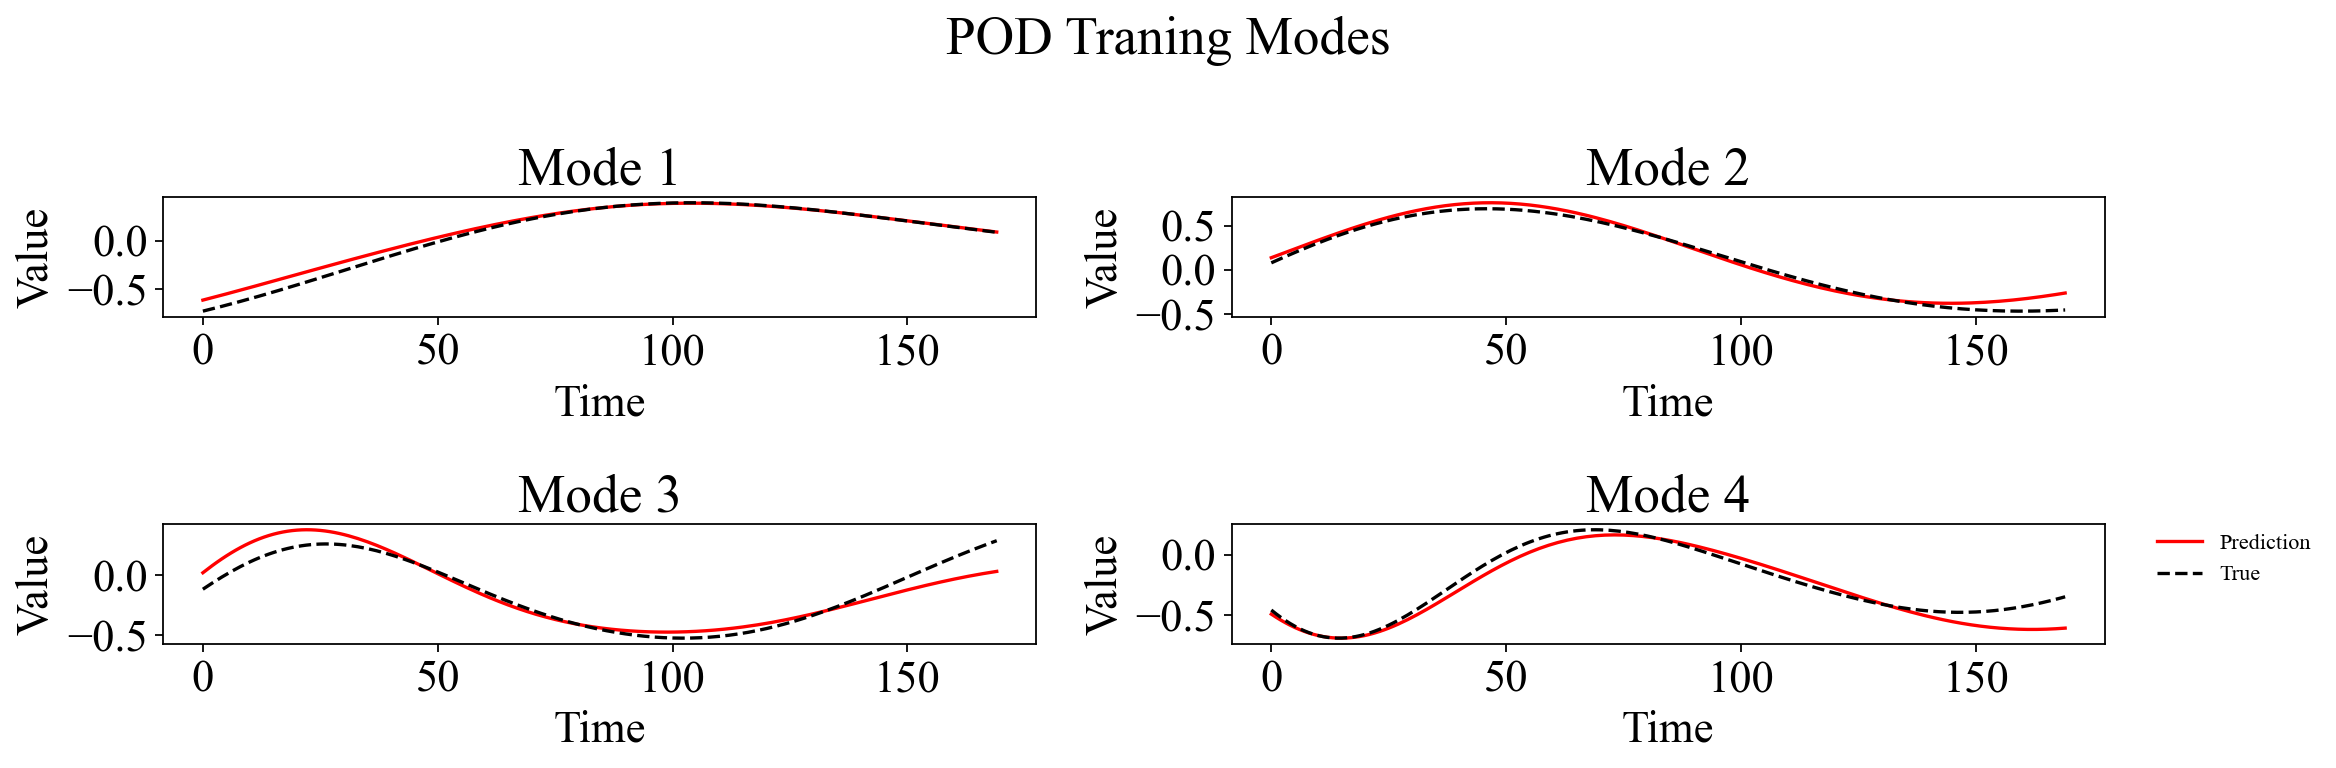

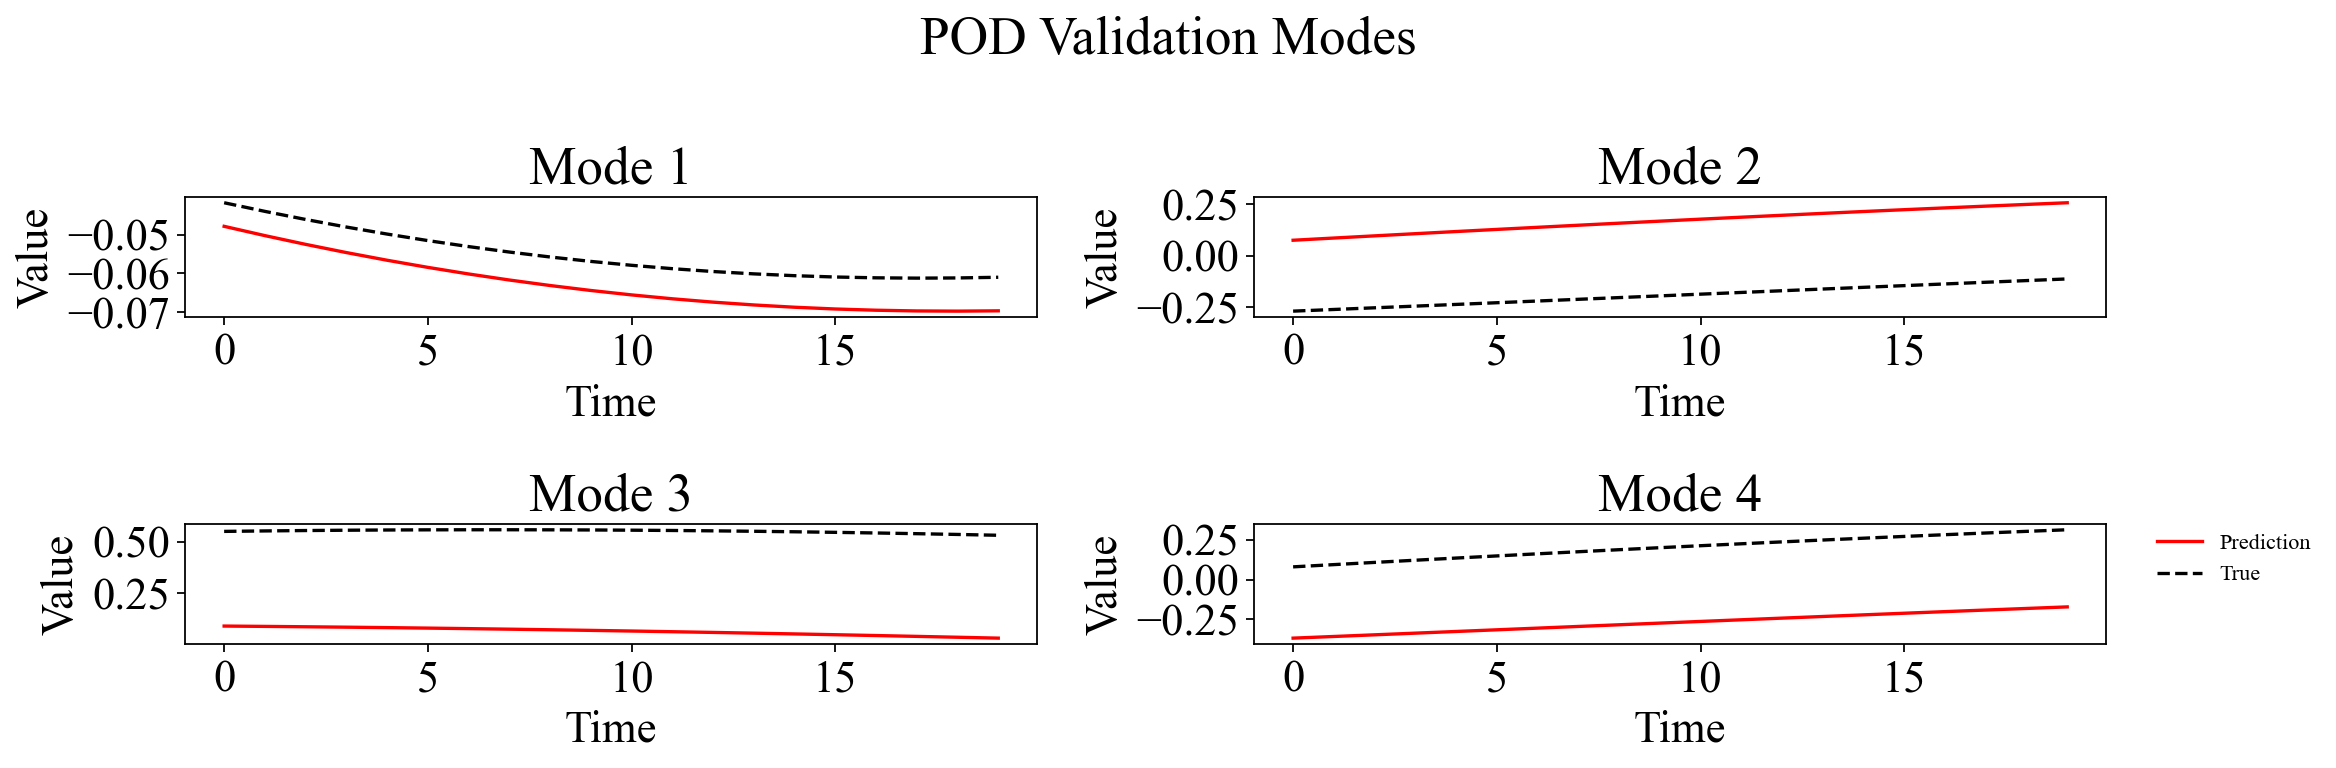

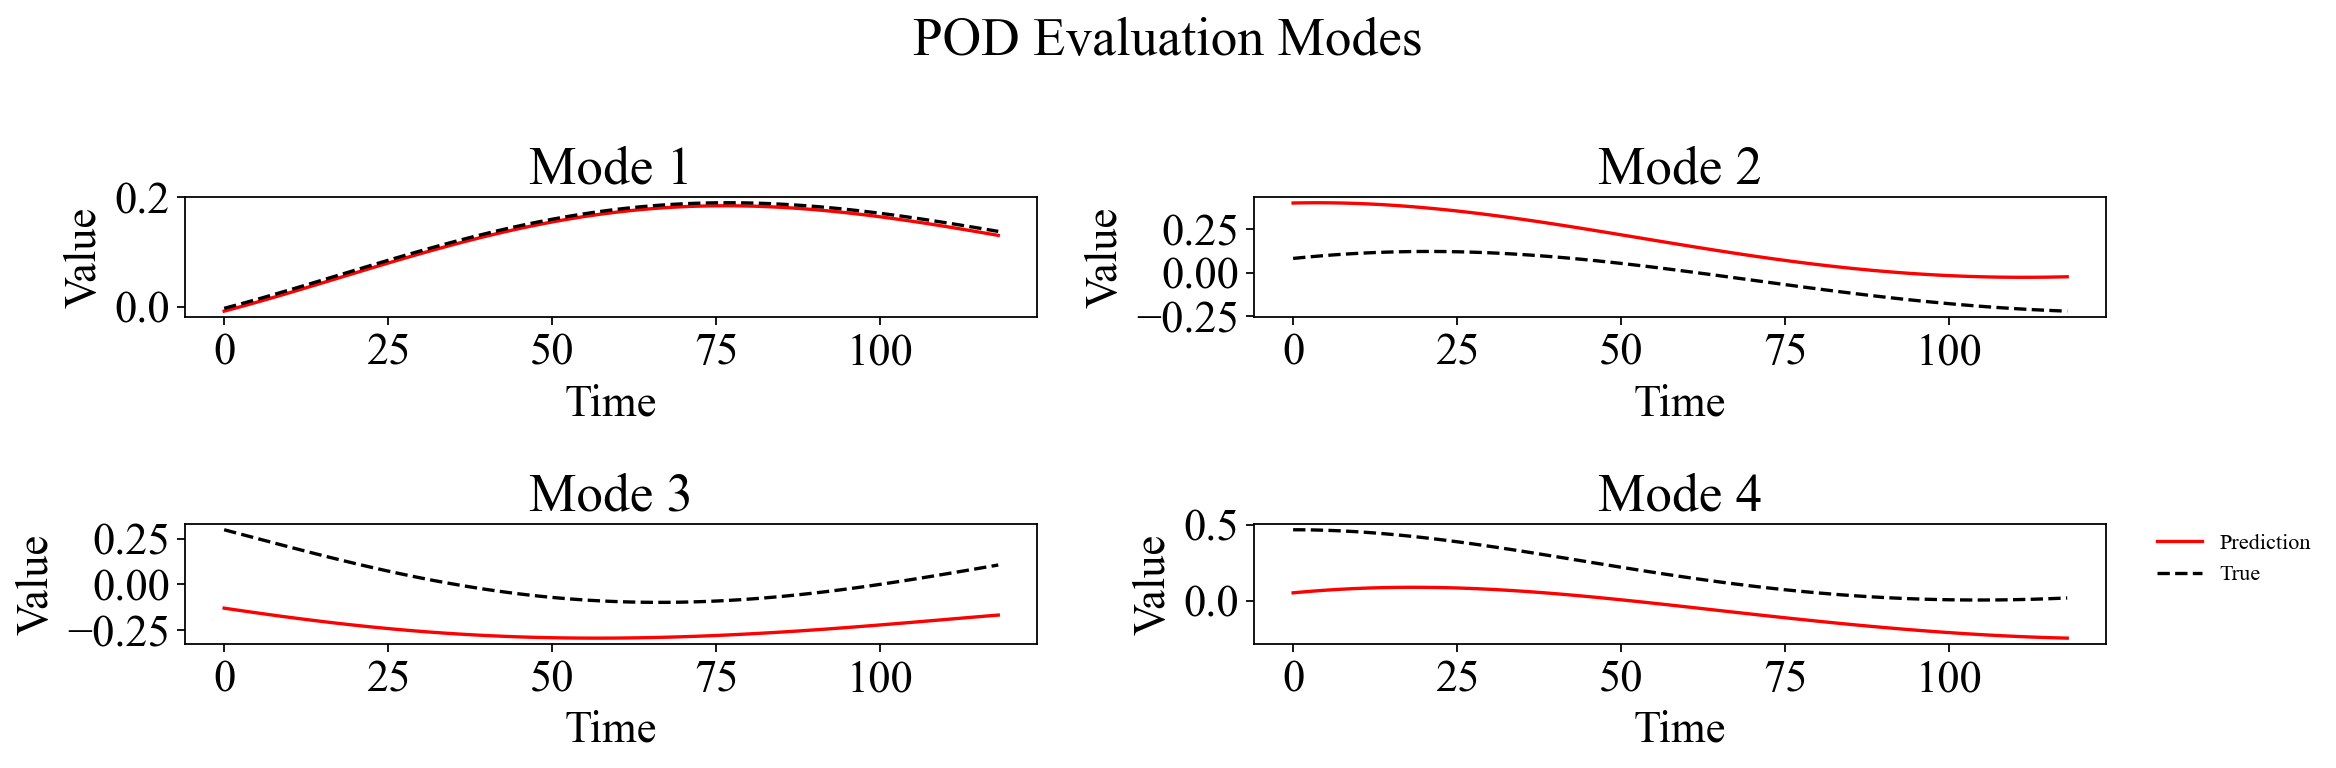

1

In [ ]:
plot_Modes(DL, model, args)

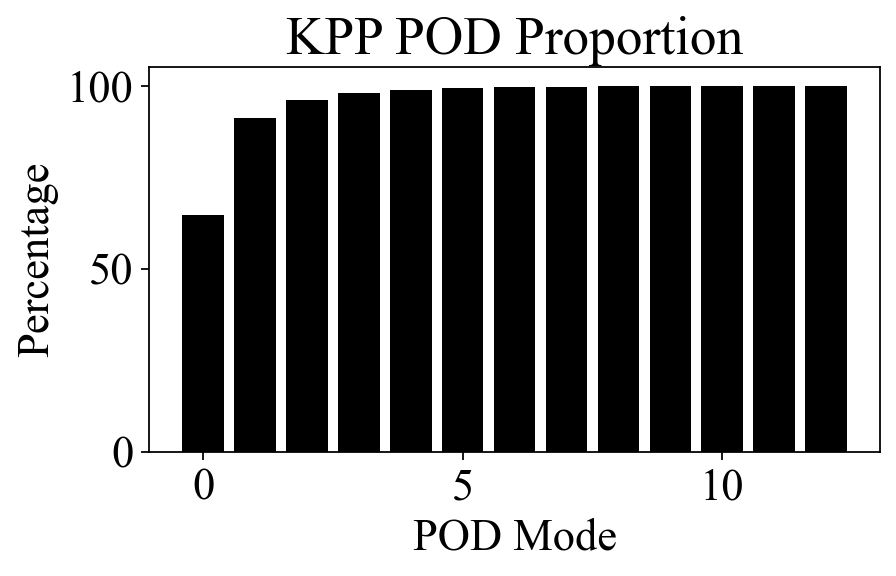

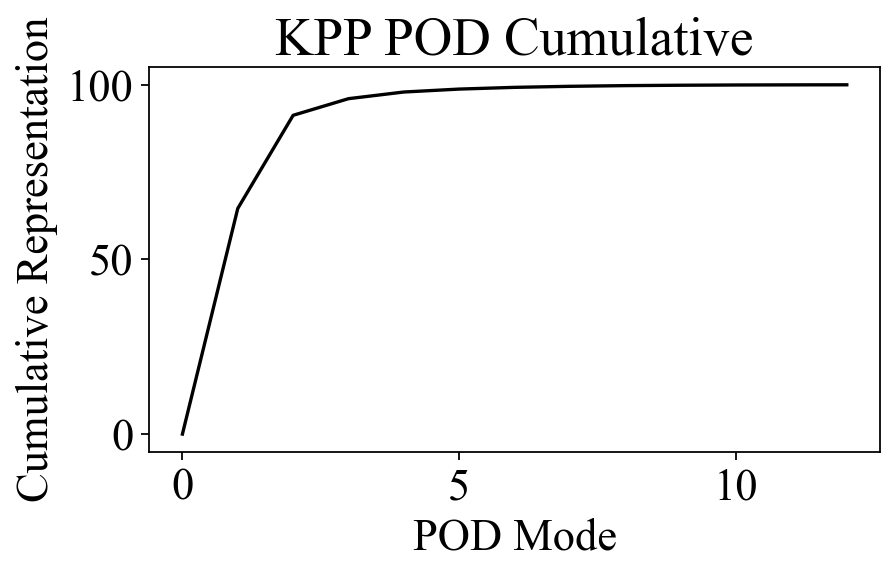

1

In [ ]:
plot_PODecay(DL,args)